# OpenAI Models - Zero Shot model
Test the classification perfomance of OpenAI LLMs.

Test cases will include:
- **Zero Shot Models**
- Embedding + XGBoost (or Cosine Similarity)
- Finetuned model

This notebook will attempt to create achieve multi-class classification by leaveraging the JSON output functionality.

## TODO
- [x] The new preview model supports setting a seed to make "reproducable" runs
- [ ] Run model multiple rounds and check reproducability
- [x] Use .env files to set API keys
- Implement token counter and optimise supplied prompts
- Return number of used promts

## Setup & Study Parameters

### Load Libraries
Load libraries and the API key

In [1]:
# --- Load libraries
# Standard libraries
import glob
import json
import os
import sys
import logging
import pickle

# Misc
import jinja2
from dotenv import load_dotenv
from tqdm.notebook import tqdm

# DS libs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pathlib import Path
from tqdm.notebook import tqdm

# ML libs
from openai import OpenAI
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score

# --- Specify logging level
logging.basicConfig(level=logging.INFO)

# --- Check the environment and load API key
print("Current work directory:", Path.cwd())

# Load API key (DO NOT HARDCODE)
load_dotenv()

if _SECRET_KEY := os.getenv("OPENAI_API_KEY"):
    logging.debug("API key found.")
    client = OpenAI(
        # defaults to os.environ.get("OPENAI_API_KEY")
        api_key=_SECRET_KEY
    )
else:
    logging.error("API key not found. Please set the environment variable OPENAI_API_KEY")

Current work directory: /home/kevinyuan/EHR-Indication-Processing/02_Models/03_LLMs/OpenAI


### Specify Study Parameters
Data paths and model to use

In [2]:
# Model parameters
model_selection = "GPT4"  # "Davinci" or "Curie" or "Babbage" or "Ada"

model_dict = {
    "GPT4": "gpt-4-1106-preview",
    # Only the following are made for chats
    "GPT3.5 Turbo": "gpt-3.5-turbo",
    # Only the following supports pure completion and text substitution
    "GPT3.5 Davinci": "text-davinci-003",
    # Only the following support finetuning, decreasing in performance and cost
    "Davinci": "davinci",
    "Curie": "curie",
    "Babbage": "babbage",
    "Ada": "ada",    
}

# --- Misc settings
# Model names
model_name_display = model_selection
model_openai_id = model_dict[model_selection]  # OpenAI name/identifier

# --- Paths
# Base data path
base_data_path = Path("../../../00_Data/")
# Data Path (training, testing, etc.)
data_path =  base_data_path / "publication_ready"
# Export Path (model checkpoints, predictions, etc.)
export_path = base_data_path / "export" / f"Zero_Shot_Table-{model_openai_id}"


assert base_data_path.is_dir(),\
  f"{base_data_path} either doesn't exist or is not a directory."
export_path.mkdir(exist_ok=True)

seed = 42

## Import and clean data
Import the test and validation data

In [3]:
# Import data --> upload into "Files" on the left-hand panel
train_eval_df = pd.read_csv(
    data_path / 'training_oxford_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

test_oxford_df = pd.read_csv(
    data_path / 'testing_oxford_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

test_banbury_df = pd.read_csv(
    data_path / 'testing_banbury_2023-08-23.csv',
    dtype={"Indication": str},
    keep_default_na=False,
    na_values=["NA"],
)

# --- Split into train and eval
train_df, eval_df = train_test_split(
    train_eval_df, 
    test_size=0.15,
    random_state=42,
    shuffle=True)

print("Data set size overview:")
print(f"- Training set: {train_df.shape[0]}")
print(f"- Evaluation set: {eval_df.shape[0]}")
print(f"- Testing Oxford set: {test_oxford_df.shape[0]}")
print(f"- Testing Banbury set: {test_banbury_df.shape[0]}")
print()

Data set size overview:
- Training set: 3400
- Evaluation set: 600
- Testing Oxford set: 2000
- Testing Banbury set: 2000



### Define labels and mappers
Convert labels to numbers and get prettier labels

In [4]:
# labels
labels = [label for label in train_df.columns if label not in ["Indication"]]
labels_pretty = [" ".join(word.capitalize() for word in label.split("_")) for label in labels]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}
labels2labels_pretty = {old:pretty for old, pretty in zip(labels, labels_pretty)}

labels_pretty

['Urinary',
 'Respiratory',
 'Abdominal',
 'Neurological',
 'Skin Soft Tissue',
 'Ent',
 'Orthopaedic',
 'Other Specific',
 'No Specific Source',
 'Prophylaxis',
 'Uncertainty',
 'Not Informative']

### Preprocess data

Not sure what's needed yet

For now get a subset of the training data:
- Extract some indications as validation data

In [5]:
test_subsample = train_df.sample(n=100)
test_subsample_indications = test_subsample.Indication

## Zero Shot Model
Create a good query to use for Zero Shot predictions

In [6]:
def request_completion(client, system_prompt, user_prompt, model_openai_id, max_tokens=100):
    """Sends the promt to the OpenAI API and returns the response.
    Specify parameters for the model in the function call.
    """
    # --- Fetch Chat Completion
    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "system",
                "content": system_prompt,
            },
            {
                "role": "user",
                "content": user_prompt,
            }
        ],
        temperature=0,  # Set lower temperature (default 0)
        max_tokens=max_tokens,
        top_p=1,  # Return only the most likely completion (save tokens)
        frequency_penalty=0,  # Default of 0, repeating sequences are ok and wanted
        presence_penalty=0,  # Set to lower value to decrease the likelyhood if the model inveting new words/categories
        model=model_openai_id,
        response_format={ "type": "json_object" },
        seed=seed,  # Set seed for reproducibility (check the API documentation for more details)
        #logit_bias  # Force the model to only reply with the specified labels?
        #logprobs  # Can it be used for evaluation?
    )
    # --- Process the response
    # -- Content
    # There will only be one completion given the parameter `top_p=1`
    chat_completion_content = chat_completion.choices[0]

    # Check whether the completion was truncated
    if (finish_reason := chat_completion_content.finish_reason) != "stop":
        logging.warning(f"Completion was truncated. Finish reason: {finish_reason}")
    
    chat_completion_message = chat_completion_content.message.content

    # -- Metadata
    # Gather general metadata
    chat_completion_metadata = {
        "model": chat_completion.model,
        "created": chat_completion.created,
        "finish_reason": finish_reason,
        "system_fingerprint": chat_completion.system_fingerprint,
    }

    # Get usage metadata
    chat_completion_usage = {
        "completion_tokens": chat_completion.usage.completion_tokens,
        "prompt_tokens": chat_completion.usage.prompt_tokens,
        "total_tokens": chat_completion.usage.total_tokens,
    }
    
    return chat_completion_message, chat_completion_metadata, chat_completion_usage

### Prompt Engineering

Promt engineering:

In [7]:
# Promt Graveyard, things that didn't quite make it
"""

--- The last line, instructing how the output should look like ---
The classifications are (one line per indication, indication is not repeated):
-> Gives the original indication

The classifications are (one line per indication, the original indication is not repeated):
-> Better, doesn't repeat the indication but returns only one catetory

The classifications are (one line per indication, multiple categories are seperated by a comma, the original indication is not repeated):
-> Repeats the indication, doesn't give multiple outputs

Return the output as one line per indication, the original indication is not repeated, if multiple categories apply, seperate them by a comma. You have to return at least one of the categories above, if none apply, return "[NA]".:
The classifications are :
-> Repeats the output again
"""
pass  # Don't echo the string (for jupyter nbs)

### Request formatting
The new API (November 2023) allows/requests to specify three messages:
1. System Prompt: Task description
2. User Prompt User input
3. Assistant Prompt: Model response

The system prompt is the same for each request (static).
The user prompt is dynamically generated and reformats the input into a table.

In [8]:
prompt_system_template_string = """You are a helpful and precise UK medical expert; you have been given a list of indications describing why antibiotics were prescribed to patients in a hospital. You have been asked to **label** these indications into categories.
You can only choose from these categories which are: {% for category in categories %}{{ category }}{% if not loop.last %}, {% endif %}{% endfor %}
Multiple categories are allowed.
{# "No Spefic Source" means a source is specified but not specific (e.g. just the word "sepsis"). "Not Informative" means the field does not reveal the source. #}When returning your answer, please return a json.
"""

prompt_user_template_string = \
"""
This is the list of indications, return a json with the categories (multiple allowed) for each indication.
{% for indication in indications -%}
"{{ indication }}",
{% endfor %}

"""

# Build the template
environment = jinja2.Environment()
prompt_user_template = environment.from_string(prompt_user_template_string)
prompt_system_template = environment.from_string(prompt_system_template_string)

Render tempalte with example data

In [9]:
# Render and display the tempaltes
prompt_system = prompt_system_template.render(categories=labels_pretty)
prompt_user = prompt_user_template.render(indications=test_subsample_indications, categories=labels_pretty)

print("System Prompt:")
print(prompt_system)
print("User Prompt:")
print(prompt_user)

System Prompt:
You are a helpful and precise UK medical expert; you have been given a list of indications describing why antibiotics were prescribed to patients in a hospital. You have been asked to **label** these indications into categories.
You can only choose from these categories which are: Urinary, Respiratory, Abdominal, Neurological, Skin Soft Tissue, Ent, Orthopaedic, Other Specific, No Specific Source, Prophylaxis, Uncertainty, Not Informative
Multiple categories are allowed.
When returning your answer, please return a json.
User Prompt:

This is the list of indications, return a json with the categories (multiple allowed) for each indication.
"sespsi",
"mastoiditis",
"post operative cover",
"gbs bacteraemia",
"prophyllaxis",
"?chest inf",
"rectovaginal fistula",
"superadded infection",
"recurrent uti",
"antenatal sepsis",
"fess",
"surg prophylaxis",
"inf",
"herpetic keratitis",
"erythroderma",
"?listeria",
"regular meds",
"possible wound infection",
"bi",
"pre-admission",
"r

### Submit Test Prompt

Send the promt to the OpenAI LLM model & wait for the response

In [10]:
chat_completion_message, chat_completion_metadata, chat_completion_usage = request_completion(
    client=client,
    system_prompt=prompt_system, 
    user_prompt=prompt_user, 
    model_openai_id=model_openai_id, 
    max_tokens=None)

print("Output")
print("------")
print(f"{chat_completion_message, chat_completion_metadata, chat_completion_usage}")
print("------")

INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Output
------
('{\n  "sespsi": ["No Specific Source"],\n  "mastoiditis": ["Ent"],\n  "post operative cover": ["Prophylaxis"],\n  "gbs bacteraemia": ["Other Specific"],\n  "prophyllaxis": ["Prophylaxis"],\n  "?chest inf": ["Respiratory", "Uncertainty"],\n  "rectovaginal fistula": ["Abdominal"],\n  "superadded infection": ["No Specific Source"],\n  "recurrent uti": ["Urinary"],\n  "antenatal sepsis": ["Other Specific"],\n  "fess": ["Ent"],\n  "surg prophylaxis": ["Prophylaxis"],\n  "inf": ["Not Informative"],\n  "herpetic keratitis": ["Other Specific"],\n  "erythroderma": ["Skin Soft Tissue"],\n  "?listeria": ["Uncertainty"],\n  "regular meds": ["Not Informative"],\n  "possible wound infection": ["Skin Soft Tissue", "Uncertainty"],\n  "bi": ["Not Informative"],\n  "pre-admission": ["Not Informative"],\n  "rx": ["Not Informative"],\n  "post appendicectomy": ["Prophylaxis"],\n  "suko": ["Not Informative"],\n  "loading dose empiric cns": ["Neurological"],\n  "infected surgical site": ["Skin

### Output parsing
Get the completion content

In [11]:
chat_completion_message.split("\n")

['{',
 '  "sespsi": ["No Specific Source"],',
 '  "mastoiditis": ["Ent"],',
 '  "post operative cover": ["Prophylaxis"],',
 '  "gbs bacteraemia": ["Other Specific"],',
 '  "prophyllaxis": ["Prophylaxis"],',
 '  "?chest inf": ["Respiratory", "Uncertainty"],',
 '  "rectovaginal fistula": ["Abdominal"],',
 '  "superadded infection": ["No Specific Source"],',
 '  "recurrent uti": ["Urinary"],',
 '  "antenatal sepsis": ["Other Specific"],',
 '  "fess": ["Ent"],',
 '  "surg prophylaxis": ["Prophylaxis"],',
 '  "inf": ["Not Informative"],',
 '  "herpetic keratitis": ["Other Specific"],',
 '  "erythroderma": ["Skin Soft Tissue"],',
 '  "?listeria": ["Uncertainty"],',
 '  "regular meds": ["Not Informative"],',
 '  "possible wound infection": ["Skin Soft Tissue", "Uncertainty"],',
 '  "bi": ["Not Informative"],',
 '  "pre-admission": ["Not Informative"],',
 '  "rx": ["Not Informative"],',
 '  "post appendicectomy": ["Prophylaxis"],',
 '  "suko": ["Not Informative"],',
 '  "loading dose empiric c

Convert the JSON return message into a indicator dataframe

In [12]:
def format_message_to_df(return_msg_str):
    # Convert the string to a dict/json
    return_msg_json = json.loads(return_msg_str)

    # Convert the dict to a DataFrame
    return_msg_df = pd.DataFrame.from_dict(return_msg_json, orient='index')

    # Apply get_dummies and sum along the columns axis, to make indicator matrix
    return_msg_df = pd.get_dummies(return_msg_df.stack().reset_index(level=1, drop=True)).groupby(level=0).sum()

    return return_msg_df

return_msg_df = format_message_to_df(chat_completion_message)

### Calculate Performance

Rename columns and sort order for the true labels

In [13]:
# Rename the labels and sort the values (as the predicted order is also sorted)
test_subsample_formatted = test_subsample\
    .rename(columns=labels2labels_pretty)\
    .sort_values(by="Indication")

In [14]:
metric_categories = [category for category in labels_pretty if category not in ["No Specific Source", "Not Informative"]]
metric_categories = [category for category in labels_pretty if category not in ["Not Informative"]]

def score_response(return_msg_df, test_subsample_formatted, metric_categories):
    # --- Get true labels
    y_test_pred = return_msg_df[metric_categories]
    y_test_true = test_subsample_formatted[metric_categories]
    # --- Calculate per-class metrics (F1 Score and ROC AUC)
    scores_per_class = {}
    scores_per_class["F1-Score"] = f1_score(y_true=y_test_true, y_pred=y_test_pred, average=None)

    scores_per_class = pd.DataFrame.from_dict(scores_per_class,orient='index', columns=metric_categories)

    pd.set_option('display.precision', 2)

    # --- Calculate overall averages (F1 Score and ROC AUC)
    scores_average = {}
    averaging_method = "weighted"
    scores_average["F1-Score"] = f1_score(y_true=y_test_true, y_pred=y_test_pred, average=averaging_method)
    return scores_average, scores_per_class

score_response(return_msg_df, test_subsample_formatted, labels_pretty)

({'F1-Score': 0.639312511545157},
           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
 F1-Score      1.0         0.93       0.91           1.0               0.8   
 
            Ent  Orthopaedic  Other Specific  No Specific Source  Prophylaxis  \
 F1-Score  0.71         0.86            0.12                 0.2         0.69   
 
           Uncertainty  Not Informative  
 F1-Score         0.89              0.0  )

## Determine maximum token input
The output of the model is limited to 4096 tokens, what is the ratio of input -> output tokens to not surpass the 
output token count?

More specifically, how many indications can we enter on average to get less than 4k tokens back?

### Theoretical Calculation
Determine the output token length based on the average number of classes.

1. Convert the indicator matrix into text
2. Convert to JSON
3. Tokenise and count

In [15]:
# SKIPPED, as Ticktoken is not exactly how GPT4 tokenises anymore...

### Experimental Validation

Run chat completion for a range of input sizes. Once run, pickle the results.

In [16]:
repeat = 1  # It's expensive... maybe just repeat it once:)
results_dict = {}

pickle_path = Path("return_metric_dict.pkl")
load_pickle = True

if not load_pickle:
    for input_size in range(100, 350, 10):
        print("Input size:", input_size)

        # Keep track of the results
        usage_list = []
        
        # Repeat the process multiple times
        for _ in range(repeat):
            # Subset the dataset
            test_subsample_indications = train_df.sample(n=input_size).Indication

            # Render the templates
            prompt_user = prompt_user_template.render(indications=test_subsample_indications, categories=labels_pretty)
            prompt_system = prompt_system_template.render(categories=labels_pretty)

            # Request the completion
            _, _, chat_completion_usage = request_completion(
                client=client,
                system_prompt=prompt_system, 
                user_prompt=prompt_user, 
                model_openai_id=model_openai_id, 
                max_tokens=None)

            # Print the results
            print(f"Usage: {chat_completion_usage}")
            usage_list.append(chat_completion_usage)

        results_dict[input_size] = usage_list

    pickle.dump(results_dict, open(pickle_path, "wb"))

else:
    results_dict = pickle.load(open(pickle_path, "rb"))

Convert the results into a usable format

In [17]:
# Take the first value in the list for now (we don't have multiple values)
results_dict_unpacked = {key: value[0] for key, value in results_dict.items()}

results_df = pd.DataFrame\
    .from_dict(results_dict_unpacked, orient='index')\
    .rename(columns={"completion_tokens": "Completion Tokens", 
                     "prompt_tokens": "Prompt Tokens", 
                     "total_tokens": "Total Tokens"
                     })

result_long_df = results_df\
    .rename_axis("Input Size")\
    .reset_index()\
    .melt(
        id_vars=["Input Size"], 
        value_vars=["Prompt Tokens", "Completion Tokens"],
        value_name="Tokens",
        var_name="Token Type")

Plot the results

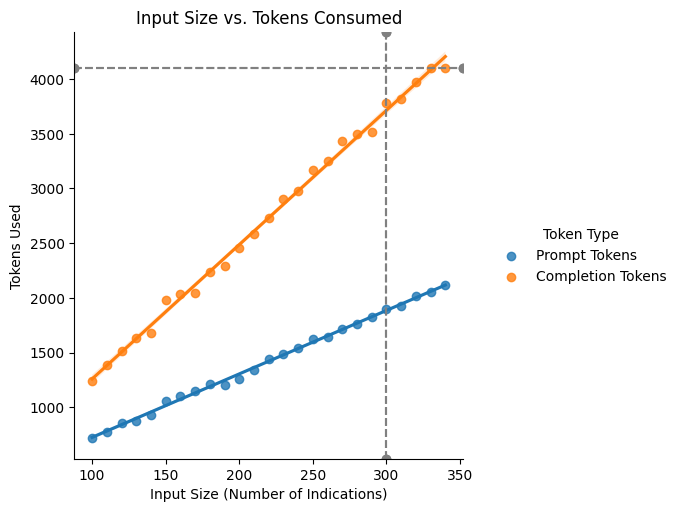

In [18]:
g = sns.lmplot(
    data=result_long_df,
    x="Input Size",
    y="Tokens",
    hue="Token Type",
    # height=6,
    # aspect=1.5,
    # legend_out=False,
)

# Add horizontal line at 4k tokens
g.refline(y=4096, x=300)
g.set(xlabel="Input Size (Number of Indications)", ylabel="Tokens Used", title="Input Size vs. Tokens Consumed")

plt.show()

Conclusion:

~330 input indications hit the return limit of 4k tokens

-> 300 input indications seem like a good choice with a 10% safety margin

## Run for the entire dataset
Use the defined methods and run the model for the whole dataset, chunk it!
Add some smartness for reruns and error handling.

In [20]:
train_pretty = train_df.rename(columns=labels2labels_pretty)[:700]
train_pretty = test_subsample.rename(columns=labels2labels_pretty)

In [21]:
chunksize = 100

input_df_length = len(train_pretty)
cursor = 0

tmp_prediction_df_list = []
prediction_metadata_list = []

# Setup progress bar
with tqdm(total=input_df_length) as p_bar:
    # Start batch processing
    while cursor < input_df_length:
        cursor_end = min(cursor+chunksize, input_df_length)

        logging.info(f"Processing chunk {cursor}:{cursor_end} of {input_df_length}")

        # Subset the dataset
        chunk = train_pretty.iloc[cursor:cursor_end]
        chunk_indications = chunk.Indication

        # Render the templates
        prompt_user = prompt_user_template.render(indications=chunk_indications, categories=labels_pretty)
        prompt_system = prompt_system_template.render(categories=labels_pretty)

        # Request the completion
        chat_completion_message, chat_completion_metadata, chat_completion_usage = request_completion(
            client=client,
            system_prompt=prompt_system, 
            user_prompt=prompt_user, 
            model_openai_id=model_openai_id, 
            max_tokens=None)
        
        # Check if output is truncated, reduce the maximum chunksize and rerun
        if chat_completion_metadata["finish_reason"] != "stop":
            chunksize = chunksize - 10
            logging.warning(f"Maximum chunksize has been reduced to {chunksize}")
            continue

        # Save the results and metadata
        chat_completion_metadata["chunk_start"] = cursor
        chat_completion_metadata["chunk_end"] = cursor_end

        tmp_prediction_df_list.append(format_message_to_df(chat_completion_message))
        prediction_metadata_list.append(chat_completion_metadata)
        
        # Show usage and continue to the next chunk
        logging.info(f"Usage: {chat_completion_usage}")
        p_bar.update(chunksize)
        cursor += chunksize

# Combine the results
prediction_df = pd.concat(tmp_prediction_df_list)
prediction_metadata_df = pd.DataFrame(prediction_metadata_list)

  0%|          | 0/100 [00:00<?, ?it/s]

INFO:root:Processing chunk 0:100 of 100


INFO:httpx:HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
INFO:root:Usage: {'completion_tokens': 1210, 'prompt_tokens': 703, 'total_tokens': 1913}


In [22]:
score_response(prediction_df, train_pretty.sort_values(by="Indication"), labels_pretty)

({'F1-Score': 0.6431192738885048},
           Urinary  Respiratory  Abdominal  Neurological  Skin Soft Tissue  \
 F1-Score      1.0         0.95       0.91           1.0               0.8   
 
            Ent  Orthopaedic  Other Specific  No Specific Source  Prophylaxis  \
 F1-Score  0.71         0.86            0.13                 0.2         0.69   
 
           Uncertainty  Not Informative  
 F1-Score         0.89              0.0  )

In [23]:
prediction_df

,Abdominal,Ent,Neurological,No Specific Source,Not Informative,Orthopaedic,Other Specific,Prophylaxis,Respiratory,Skin Soft Tissue,Uncertainty,Urinary
?anastamotic leak,1,0,0,0,0,0,0,0,0,0,1,0
?chest inf,0,0,0,0,0,0,0,0,1,0,1,0
?covid,0,0,0,0,0,0,0,0,1,0,1,0
?fungal chest,0,0,0,0,0,0,0,0,1,0,1,0
?listeria,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
tazocin stepdown,0,0,0,0,1,0,0,0,0,0,0,0
tb prophylaxis,0,0,0,0,0,0,0,1,0,0,0,0
thumb infection,0,0,0,0,0,0,0,0,0,1,0,0
wound infx,0,0,0,0,0,0,0,0,0,1,0,0
